# End-to-end Machine Learning Pipeline

## Data
This dataset provides hourly traffic volume for a city, including features indicating holidays and weather conditions.
The files used here span from 1st January 2013 to 31st December 2013. The data is acquired from the Minnesota Department of Transportation (www.dot.state.mn.us). The features are shown below:

Attributes:
- `holiday`: US national and regional holidays
- `temp`: average temperature in Kelvin (K)
- `rain_1h`: rain that occured in the hour (mm)
- `snow_1h`: snow that occured in the hour (mm)
- `clouds_all`: percentage of cloud cover
- `weather main`: textual description of current weather
- `weather_description`: longer textual description of current weather
- `date_time`: hour of the data collected in local time

Attribute (Output):
- `traffic_volume`: hourly I-94 reported westbound traffic volume



## Objective
We would like to predict the traffic volume based on the attributes mentioned above.

In [22]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import io
import os
import requests
import datetime as dt 
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
url="https://aisgaiap.blob.core.windows.net/aiap5-assessment-data/traffic_data.csv"
s=requests.get(url).content
dat=pd.read_csv(io.StringIO(s.decode('utf-8')))
dat.head(5)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,New Years Day,263.49,0.0,0,58,Clouds,broken clouds,2013-01-01 00:00:00,1439
1,None,263.78,0.0,0,40,Clouds,scattered clouds,2013-01-01 01:00:00,1502
2,None,264.16,0.0,0,75,Snow,heavy snow,2013-01-01 02:00:00,933
3,None,263.95,0.0,0,90,Clouds,overcast clouds,2013-01-01 03:00:00,576
4,None,263.65,0.0,0,90,Clouds,overcast clouds,2013-01-01 04:00:00,372


In [23]:
# Data processing
dat['date_time'] = pd.to_datetime(dat['date_time'])

def when_was_it(x):
    if x.hour >= 5 and x.hour < 10:
        return "Morning Rush (5-10)"
    elif x.hour >= 10 and x.hour < 15:
        return "Office Hours (10-15)"
    elif x.hour >= 15 and x.hour < 19:
        return "Afternoon Rush (15-19)"
    elif x.hour >= 19 and x.hour < 23:
        return "Evening (19-23)"
    else:
        return "Night (23-5)"


# Create a new column for categories of time
dat['Time'] = dat['date_time'].apply(when_was_it)
#dat['Time']


# Create a new column for month
def get_month(x):
    if x.month == 1:
        return "January"
    if x.month == 2:
        return "February"
    if x.month == 3:
        return "March"
    if x.month == 4:
        return "April"
    if x.month == 5:
        return "May"
    if x.month == 6:
        return "June"
    if x.month == 7:
        return "July"
    if x.month == 8:
        return "August"
    if x.month == 9:
        return "September"
    if x.month == 10:
        return "October"
    if x.month == 11:
        return "November"
    if x.month == 12:
        return "December"
dat['Month'] = dat['date_time'].apply(get_month)


def is_holiday(x):
    if x != "None":
        return 1
    else:
        return 0
dat['Is_holiday'] = dat['holiday'].apply(is_holiday)



dat['is_weekday'] = dat['date_time'].dt.day_name()
def is_weekday(x):
    if (x == "Saturday") or (x == "Sunday") :
        return 0
    else:
        return 1
dat['is_weekday'] = dat['is_weekday'].apply(is_weekday)
dat = dat.drop(['holiday','snow_1h','clouds_all','weather_description','date_time'],axis=1)
dat = dat[['Is_holiday', 'temp','rain_1h','weather_main','Time','is_weekday','Month','traffic_volume']]
#dat.head(30)

In [24]:
# One hot encoding for Month, Time and Weather

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# For each categorical column
# We fit a label encoder, transform our column and 
# add it to our new dataframe
label_encoders = {}
dat_processed = dat[['weather_main','Time','Month']]
cat_columns = ['weather_main','Time','Month']
for col in cat_columns:
    print("Encoding {}".format(col))
    new_le = LabelEncoder()
    dat_processed[col] = new_le.fit_transform(dat[col])
    label_encoders[col] = new_le
#dat_processed

cat_columns_idx = [dat_processed.columns.get_loc(col) 
                   for col in cat_columns]
#cat_columns_idx
ohe = OneHotEncoder(categorical_features=cat_columns_idx, 
                    sparse=False, handle_unknown="ignore")
dat_processed_np = ohe.fit_transform(dat_processed)
dat_processed_np = pd.DataFrame(dat_processed_np)

dat1 = dat.drop(['weather_main','Time','Month'], axis = 1)
dat1 = pd.concat([dat_processed_np,dat1],axis=1)
#dat1


Encoding weather_main
Encoding Time
Encoding Month


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [25]:
from sklearn.model_selection import train_test_split

X = dat1.drop(['traffic_volume'], axis = 1)
Y = dat1['traffic_volume']

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)
X_train.head(5)

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,Is_holiday,temp,rain_1h,is_weekday
7868,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,264.46,0.0,1
2223,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,279.84,0.0,1
1567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0,266.83,0.0,1
3780,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0,284.23,0.0,1
6468,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0,296.41,0.0,1


In [26]:
# Scaling of the features: rain_1h and temperature

from sklearn.preprocessing import MinMaxScaler #Importing Scaler

X_train1 = X_train.iloc[:,].values
X_test1 = X_test.iloc[:,].values

scaler_x = MinMaxScaler()

X_train_scaled = scaler_x.fit_transform(X_train1)
X_test_scaled = scaler_x.fit_transform(X_test1)
X_train_scaled = pd.DataFrame(X_train1)
X_test_scaled = pd.DataFrame(X_test1)

In [27]:
# Obtaining the Linear Regression coefficients and Feature Normalization 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

linridge = LinearRegression().fit(X_train_scaled, y_train)

print('Linear regression linear model intercept: {}'
     .format(linridge.intercept_))
print('Linear regression linear model coeff:\n{}'
     .format(linridge.coef_))
print('R-squared score (training): {:.3f}'
     .format(linridge.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linridge.score(X_test_scaled, y_test)))
print('Number of non-zero features: {}'
     .format(np.sum(linridge.coef_ != 0)))

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

print('RMSE score (test): {:.3f}'
     .format(rmse(linridge.predict(X_test_scaled),y_test)))
linreg_accuracy = rmse(linridge.predict(X_test_scaled),y_test)


Linear regression linear model intercept: -133667737654027.75
Linear regression linear model coeff:
[ 1.33667738e+14  1.33667738e+14  1.33667738e+14  1.33667738e+14
  1.33667738e+14  1.33667738e+14  1.33667738e+14  1.33667738e+14
  1.33667738e+14  1.33667738e+14  1.69398622e+03 -7.03173809e+02
  5.51794012e+02 -2.73916282e+03  1.19702817e+03  4.19678196e+01
  6.57992421e+01 -1.83953518e+02  7.72322698e+00 -7.21308830e+01
 -1.14670401e+02  6.67290081e+00  4.41128801e+01 -8.09711365e+01
  1.99421261e+01  2.20489966e+02  4.47877783e+01 -1.81330408e+02
  1.03263928e+01 -2.61867473e+01  1.00408581e+03]
R-squared score (training): 0.743
R-squared score (test): 0.765
Number of non-zero features: 31
RMSE score (test): 988.830


In [28]:
# Obtaining the Ridge Regression coefficients and Feature Normalization 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

linridge = Ridge(alpha=0.5).fit(X_train_scaled, y_train)

print('ridge regression linear model intercept: {}'
     .format(linridge.intercept_))
print('ridge regression linear model coeff:\n{}'
     .format(linridge.coef_))
print('R-squared score (training): {:.3f}'
     .format(linridge.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linridge.score(X_test_scaled, y_test)))
print('Number of non-zero features: {}'
     .format(np.sum(linridge.coef_ != 0)))

print('RMSE score (test): {:.3f}'
     .format(rmse(linridge.predict(X_test_scaled),y_test)))


# Choosing the optimal value of Alpha in ridge regression
ridge_accuracy_arr = np.array([0])
print('Ridge regression: effect of alpha regularization parameter\n')
for this_alpha in [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1, 10, 20, 50, 100, 1000]:
    linridge = Ridge(alpha = this_alpha).fit(X_train_scaled, y_train)
    r2_train = linridge.score(X_train_scaled, y_train)
    r2_test = linridge.score(X_test_scaled, y_test)
    rmse_test = rmse(linridge.predict(X_test_scaled),y_test)
    ridge_accuracy_arr = np.append(ridge_accuracy_arr, rmse_test)
    num_coeff_bigger = np.sum(abs(linridge.coef_) > 1.0)
    print('Alpha = {:.2f}\nnum abs(coeff) > 1.0: {}, \
r-squared training: {:.4f}, r-squared test: {:.4f}\n'
         .format(this_alpha, num_coeff_bigger, r2_train, r2_test))
    print('Alpha = {:.2f}\nnum abs(coeff) > 1.0: {}, \
rmse training: {:.4f}\n'
         .format(this_alpha, num_coeff_bigger, rmse_test))

ridge_accuracy = np.amin(ridge_accuracy_arr[1:])

ridge regression linear model intercept: -118.99342249159781
ridge regression linear model coeff:
[   25.20417086    16.31175789    24.40011651   -31.13408608
  -141.88065671   -55.40151334   -14.71787462   -68.45911626
   249.9412792     -4.26407745  1693.11618728  -702.85727622
   551.57431009 -2738.33902062  1196.50579947    41.99188669
    65.62882138  -183.8074342      7.68370921   -71.78307846
  -114.70378459     6.62568854    44.13516555   -80.72143305
    20.25591587   220.13333797    44.56120509  -172.47508041
    10.35586523   -26.04684926  1003.64656512]
R-squared score (training): 0.743
R-squared score (test): 0.765
Number of non-zero features: 31
RMSE score (test): 988.841
Ridge regression: effect of alpha regularization parameter

Alpha = 0.00
num abs(coeff) > 1.0: 31, r-squared training: 0.7427, r-squared test: 0.7651

Alpha = 0.00
num abs(coeff) > 1.0: 31, rmse training: 988.8529

Alpha = 0.10
num abs(coeff) > 1.0: 31, r-squared training: 0.7427, r-squared test: 0.7651


In [29]:
# Random Forest Regression

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state = 0)

from pprint import pprint
from sklearn.grid_search import GridSearchCV  

# To use GridSearchCV, we first need to create a parameter grid to sample from during fitting:

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 200, num = 20)]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 15, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 5,7,9]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,3,4]
# Method of selecting samples for training each tree
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }
pprint(random_grid)

# Random Search Training
# Now, we instantiate the random search and fit it like any Scikit-Learn model:

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
# rf_random = GridSearchCV(estimator = rf, param_grid = random_grid, cv =3, verbose=2)
# Fit the random search model
# rf_random.fit(X_train_scaled, y_train)
# rf_random.best_params_

# Output from Hyper-parameter tuning
# Parallel(n_jobs=1)]: Done 13200 out of 13200 | elapsed: 158.3min finished
# Out[8]:
# {'max_depth': 11,
#  'max_features': 'auto',
#  'min_samples_leaf': 2,
#  'min_samples_split': 5,
#  'n_estimators': 117}


{'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 15, None],
 'max_features': ['auto'],
 'min_samples_leaf': [1, 2, 3, 4],
 'min_samples_split': [2, 3, 5, 7, 9],
 'n_estimators': [5,
                  15,
                  25,
                  35,
                  46,
                  56,
                  66,
                  76,
                  87,
                  97,
                  107,
                  117,
                  128,
                  138,
                  148,
                  158,
                  169,
                  179,
                  189,
                  200]}


We have tried to tune the following set of hyperparameters:
- 'n_estimators' = number of trees in the foreset
- 'max_features' = max number of features considered for splitting a node
- 'max_depth' = max number of levels in each decision tree
- 'min_samples_split' = min number of data points placed in a node before the node is split
- 'min_samples_leaf' = min number of data points allowed in a leaf node
- 'bootstrap' = method for sampling data points (with or without replacement)

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV  

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = np.sum((predictions - test_labels)**2)
    rmse = np.sqrt(errors/test_features.shape[0])
    print('Model Performance')
    print('RMSE: {:0.4f}'.format(rmse))
    return rmse

print('Random Forest Regressor (Post-tuning)')
best_rf_model = RandomForestRegressor(n_estimators=117, max_features='auto',max_depth=11,min_samples_split=5,min_samples_leaf=2)
best_rf_model.fit(X_train_scaled, y_train)
random_accuracy = evaluate(best_rf_model, X_test_scaled, y_test)
random_accuracy

print('Random Forest Regressor (Pre-tuning)')
base_model = RandomForestRegressor(n_estimators = 10, random_state = 0)
base_model.fit(X_train_scaled, y_train)
base_accuracy = evaluate(base_model, X_test_scaled, y_test)

print('Improvement of {:0.2f}%.'.format( -100 * (random_accuracy - base_accuracy) / base_accuracy))

Random Forest Regressor (Post-tuning)
Model Performance
RMSE: 781.4653
Random Forest Regressor (Pre-tuning)
Model Performance
RMSE: 832.4779
Improvement of 6.13%.


In [31]:
# Boosted Regression Trees

import xgboost
from xgboost import plot_importance
from sklearn.grid_search import GridSearchCV   #Performing grid search



#for tuning parameters
# param_grid = {
#    'colsample_bytree':[0.4,0.6],
#    'gamma':[0.05,0.1],
#    'min_child_weight':[1.5,6],
#    'learning_rate':[0.1,0.07],
#    'max_depth':[int(x) for x in np.linspace(8, 13, num = 6)],
#    'n_estimators':[int(x) for x in np.linspace(start = 50, stop = 150, num = 5)],
#    'reg_alpha':[1e-5,  0.5],
#    'reg_lambda':[1e-5, 0.45],
#    'subsample':[0.6,0.95]  
# }

                    
# xgb_model = xgboost.XGBRegressor(learning_rate =0.1, n_estimators=10, max_depth=5,
#     min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=0)

# gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = param_grid, n_jobs = 6, iid=False, verbose=10,scoring='neg_mean_squared_error')
# gsearch1.fit(X_train_scaled, y_train)
# print (gsearch1.grid_scores_)
# print('best params')
# print (gsearch1.best_params_)
# print('best score')
# print (gsearch1.best_score_)

# Output from Hyper-parameter tuning
# [Parallel(n_jobs=6)]: Done 11520 out of 11520 | elapsed: 59.2min finished
# best_xgb_model = xgboost.XGBRegressor(colsample_bytree=0.6,
#                  gamma=0.05,                 
#                  learning_rate=0.07,
#                  max_depth=8,
#                  min_child_weight=1.5,
#                  n_estimators=100,                                                                    
#                  reg_alpha=1e-05,
#                  reg_lambda=0.45,
#                  subsample=0.95)       

[Text(0,0,'Is_Mist'),
 Text(0,0,'Is_Clear'),
 Text(0,0,'Is_Clouds'),
 Text(0,0,'Rainfall 1hour'),
 Text(0,0,'Temperature')]

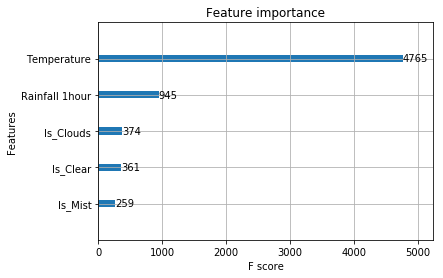

In [32]:
#print (gsearch1.best_params_)
best_xgb_model = xgboost.XGBRegressor(colsample_bytree=0.6,
                 gamma=0.05,                 
                 learning_rate=0.07,
                 max_depth=8,
                 min_child_weight=1.5,
                 n_estimators=100,                                                                    
                 reg_alpha=1e-05,
                 reg_lambda=0.45,
                 subsample=0.95)
best_xgb_model.fit(X_train_scaled, y_train)

plot_importance(best_xgb_model, max_num_features = 5).set_yticklabels(['Is_Mist','Is_Clear','Is_Clouds','Rainfall 1hour','Temperature'])  # top most important features


In [33]:
import xgboost
best_xgb_model = xgboost.XGBRegressor(colsample_bytree=0.6,
                 gamma=0.05,                 
                 learning_rate=0.07,
                 max_depth=8,
                 min_child_weight=1.5,
                 n_estimators=100,                                                                    
                 reg_alpha=1e-05,
                 reg_lambda=0.45,
                 subsample=0.95)
best_xgb_model.fit(X_train_scaled, y_train)




print('XGBoost Regressor (Post-tuning)')
XGB_accuracy = evaluate(best_xgb_model, X_test_scaled, y_test)
#XGB_accuracy



XGBoost Regressor (Post-tuning)
Model Performance
RMSE: 775.4962


In [34]:
# Results of trained models


# logistic Regression
print('Model Performance for Logistic Regression')
print('RMSE: {:0.4f}'.format(linreg_accuracy))
print('Model Performance for Ridge Regression')
print('RMSE: {:0.4f}'.format(ridge_accuracy)) 
print('Model Performance for Random Forest')
print('RMSE: {:0.4f}'.format(random_accuracy))
print('Model Performance for XGBoost')
print('RMSE: {:0.4f}'.format(XGB_accuracy)) 

Model Performance for Logistic Regression
RMSE: 988.8300
Model Performance for Ridge Regression
RMSE: 988.8290
Model Performance for Random Forest
RMSE: 781.4653
Model Performance for XGBoost
RMSE: 775.4962


## Models trained

- Performance for Logistic Regression
RMSE: 988.8300
- Performance for Ridge Regression
RMSE: 988.8290
- Performance for Random Forest
RMSE: 781.0434
- Performance for XGBoost: RMSE: 775.4962

XGBoost is the best performing model for the prediction of traffic volume